# NER: Flair and BERT evaluation using softmax probabilities

**Contents:**

- Predictions

- Timings

- Confusion matrices, precision, recall, f1-scores

- Classification probabilities and analysis of chosen sentences

- The words that are categorised as MISC

- Calibration

In [350]:
# general
import numpy as np
import time
import torch
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.calibration import calibration_curve

# models
from danlp.models import load_bert_ner_model, load_flair_ner_model

# dataset
from danlp.datasets import DDT

# utils
from flair.data import Sentence, Token

In [2]:
# load models
bert = load_bert_ner_model()
flair = load_flair_ner_model()

# get data (splitted into a training set, a validation set, and a test set)
ddt = DDT()
train, valid, test = ddt.load_as_simple_ner(True)

2021-01-13 13:05:27,956 loading file /Users/jorgentaule/.danlp/flair.ner.pt


In [3]:
# divide the observations and the targets of the testset into new variables
sentences, categories = test

### Get predictions

In [710]:
def get_bert_predictions():
    start = time.time()
    
    predictions_list = []
    output_probabilities = []
    
    for sentence in sentences:
        tokens = []
        tokens_mask = [1]
        for word in sentence:
            word_tokens = bert.tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            tokens_mask.extend([1]+[0]*(len(word_tokens)-1))
        tokens_mask.extend([1])

        inputs = bert.tokenizer.encode(tokens, return_tensors="pt")
        
        outputs = bert.model(inputs)[0]
        
        softmax = torch.nn.Softmax(dim=1)
        outputs = torch.Tensor(softmax(outputs[0])).view(outputs.shape)
        
        

        predictions = torch.argmax(outputs, dim=2)

        # Mask the predictions so we only get the labels for the
        # pre-tokenized text
        predictions = [prediction for prediction, mask in zip(predictions[0].tolist(), tokens_mask) if mask]
        outputs = [[out for out, mask in zip(outputs[0].tolist(), tokens_mask) if mask]]
        outputs = torch.Tensor(outputs)
        outputs = outputs[0][1:-1]
        predictions = predictions[1:-1]  # Remove special tokens
        
        output_probabilities.append(outputs)

        # Map prediction ids to labels
        predictions = [bert.label_list[label] for label in predictions]
        
        predictions_list.append(predictions)
    
    time_spent = time.time()-start
    
    return predictions_list, time_spent, output_probabilities

In [ ]:
bert_times = []
for i in range(5):
    bert_preds, bert_time_spent, _ = get_bert_predictions()
    bert_times.append(bert_time_spent)

In [404]:
def get_flair_predictions():
    start = time.time()
    
    predictions = []
    
    flair_sentences = []
    for sentence in sentences:
        flair_sentence = Sentence()
        for token in sentence:
            flair_sentence.add_token(Token(token))
        flair_sentences.append(flair_sentence)
    flair.predict(flair_sentences)
    
    for s in flair_sentences:
        predicted_categories = []
        for t in s:
            predicted_categories.append(t.tags['ner'].value)
        predictions.append(predicted_categories)
    
    time_spent = time.time()-start
    
    return predictions, time_spent

In [ ]:
flair_times = []
for i in range(5):
    flair_preds, flair_time_spent = get_flair_predictions()
    flair_times.append(flair_time_spent)

### Timings

In [409]:
bert_times, np.mean(bert_times)

([71.42963981628418,
  61.58659029006958,
  70.86726903915405,
  62.72152590751648,
  62.91023898124695],
 65.90305280685425)

In [410]:
flair_times, np.mean(flair_times)

([30.398699045181274,
  27.56198215484619,
  34.125170946121216,
  35.18169689178467,
  40.92761993408203],
 33.639033794403076)

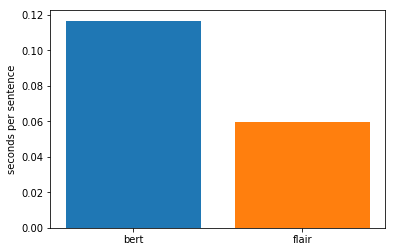

The FlairNer model is 1.96 times faster then BertNer.


In [411]:
x = [0, 1]
plt.bar(x[0], height=np.mean(bert_times)/len(sentences))
plt.bar(x[1], height=np.mean(flair_times)/len(sentences))
plt.xticks(x, ['bert', 'flair'])
plt.ylabel('seconds per sentence')
plt.show()
bert_time_spent/flair_time_spent
print('The FlairNer model is {:.3} times faster then BertNer.'.format(np.mean(bert_times)/np.mean(flair_times)))

## Confusion matrices, precision, recall, f1-scores

Precision: how many of the predicted instances of a class were actually correct?

Recall: how many instances in a class were identified by the model?

f1: gives a more realitic picture of a balance between precision and recall when there is a large class imbalance.

In [346]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes
    source: https://gist.github.com/zachguo/10296432"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t/p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.0f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [333]:
flair_preds_flattened = [item for sublist in flair_preds for item in sublist]
bert_preds_flattened = [item for sublist in bert_preds for item in sublist]
categories_flattened = [item for sublist in categories for item in sublist]

In [341]:
bert_cm = confusion_matrix(categories_flattened, bert_preds_flattened, labels=bert.label_list)
flair_cm = confusion_matrix(categories_flattened, flair_preds_flattened, labels=bert.label_list)

In [389]:
categories_nomisc_flattened = deepcopy(categories_flattened)
labels_nomisc = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

for i, token in enumerate(categories_nomisc_flattened):
    if token=='B-MISC' or token=='I-MISC':
        categories_nomisc_flattened[i]='O'
        
bert_cm_nomisc = confusion_matrix(categories_nomisc_flattened, bert_preds_flattened, labels=labels_nomisc)
flair_cm_nomisc = confusion_matrix(categories_nomisc_flattened, flair_preds_flattened, labels=labels_nomisc)

In [395]:
categories_nomisc_noIB_flattened = deepcopy(categories_nomisc_flattened)
bert_preds_noIB_flattened = deepcopy(bert_preds_flattened)
flair_preds_noIB_flattened = deepcopy(flair_preds_flattened)

for i, token in enumerate(bert_preds_noIB_flattened):
    if token!='O':
        bert_preds_noIB_flattened[i]=token[2:]

for i, token in enumerate(flair_preds_noIB_flattened):
    if token!='O':
        flair_preds_noIB_flattened[i]=token[2:]
        
for i, token in enumerate(categories_nomisc_noIB_flattened):
    if token!='O':
        categories_nomisc_noIB_flattened[i]=token[2:]

labels_noIB = ['O', 'PER', 'ORG', 'LOC']

bert_cm_noIB = confusion_matrix(
    categories_nomisc_noIB_flattened, bert_preds_noIB_flattened, labels=labels_noIB)
flair_cm_noIB = confusion_matrix(
    categories_nomisc_noIB_flattened, flair_preds_noIB_flattened, labels=labels_noIB)

#### BERT confusion matrix with MISC

In [347]:
print_cm(bert_cm, labels=bert.label_list)

      t/p       O B-MISC I-MISC  B-PER  I-PER  B-ORG  I-ORG  B-LOC  I-LOC 
         O   9214      0      0      1      0      4      1      2      2 
    B-MISC    111      0      0      0      0     10      0      0      0 
    I-MISC     36      0      0      1      0      0      1      0      0 
     B-PER     10      0      0    168      0      1      0      1      0 
     I-PER      0      0      0      0    138      0      0      0      0 
     B-ORG     25      0      0     11      0    106      0     19      0 
     I-ORG      8      0      0      0      3      1     33      0     15 
     B-LOC      9      0      0      0      0      1      0     86      0 
     I-LOC      1      0      0      0      0      0      0      0      4 


#### BERT confusion matrix without MISC

In [362]:
print_cm(bert_cm_nomisc, labels=labels_nomisc)

     t/p      O B-PER I-PER B-ORG I-ORG B-LOC I-LOC 
        O  9214     1     0     4     1     2     2 
    B-PER    10   168     0     1     0     1     0 
    I-PER     0     0   138     0     0     0     0 
    B-ORG    25    11     0   106     0    19     0 
    I-ORG     8     0     3     1    33     0    15 
    B-LOC     9     0     0     1     0    86     0 
    I-LOC     1     0     0     0     0     0     4 


#### BERT precision, recall, f1-score without MISC

In [363]:
print(classification_report(categories_nomisc_flattened, bert_preds_flattened, labels=labels_nomisc))

              precision    recall  f1-score   support

           O       0.98      1.00      0.99      9224
       B-PER       0.93      0.93      0.93       180
       I-PER       0.98      1.00      0.99       138
       B-ORG       0.86      0.66      0.75       161
       I-ORG       0.94      0.55      0.69        60
       B-LOC       0.80      0.90      0.84        96
       I-LOC       0.19      0.80      0.31         5

   micro avg       0.97      0.99      0.98      9864
   macro avg       0.81      0.83      0.79      9864
weighted avg       0.97      0.99      0.98      9864



#### BERT confusion matrix without MISC, B-, I-

In [398]:
print_cm(bert_cm_noIB, labels=labels_noIB)

     t/p      O   PER   ORG   LOC 
        O  9361     2    16     4 
      PER    10   306     1     1 
      ORG    33    14   140    34 
      LOC    10     0     1    90 


#### BERT precision, recall, f1-score without MISC, B-, I-

In [399]:
print(classification_report(
    categories_nomisc_noIB_flattened, bert_preds_noIB_flattened, labels=labels_noIB))

              precision    recall  f1-score   support

           O       0.99      1.00      1.00      9383
         PER       0.95      0.96      0.96       318
         ORG       0.89      0.63      0.74       221
         LOC       0.70      0.89      0.78       101

    accuracy                           0.99     10023
   macro avg       0.88      0.87      0.87     10023
weighted avg       0.99      0.99      0.99     10023



#### FLAIR confusion matrix with MISC

In [348]:
print_cm(flair_cm, labels=bert.label_list)

      t/p       O B-MISC I-MISC  B-PER  I-PER  B-ORG  I-ORG  B-LOC  I-LOC 
         O   9222      0      0      0      0      0      2      0      0 
    B-MISC    112      0      0      0      0      5      0      4      0 
    I-MISC     37      0      0      1      0      0      0      0      0 
     B-PER      8      0      0    170      0      1      0      1      0 
     I-PER      0      0      0      0    138      0      0      0      0 
     B-ORG     59      0      0     13      0     81      0      8      0 
     I-ORG     12      0      0      0      5      1     42      0      0 
     B-LOC     10      0      0      1      0      2      1     82      0 
     I-LOC      2      0      0      0      0      0      1      0      2 


#### FLAIR confusion matrix without MISC

In [361]:
print_cm(flair_cm_nomisc, labels=labels_nomisc)

     t/p      O B-PER I-PER B-ORG I-ORG B-LOC I-LOC 
        O  9222     0     0     0     2     0     0 
    B-PER     8   170     0     1     0     1     0 
    I-PER     0     0   138     0     0     0     0 
    B-ORG    59    13     0    81     0     8     0 
    I-ORG    12     0     5     1    42     0     0 
    B-LOC    10     1     0     2     1    82     0 
    I-LOC     2     0     0     0     1     0     2 


#### FLAIR precision, recall, f1-score without MISC

In [360]:
print(classification_report(categories_nomisc_flattened, flair_preds_flattened, labels=labels_nomisc))

              precision    recall  f1-score   support

           O       0.97      1.00      0.99      9224
       B-PER       0.92      0.94      0.93       180
       I-PER       0.97      1.00      0.98       138
       B-ORG       0.90      0.50      0.65       161
       I-ORG       0.91      0.70      0.79        60
       B-LOC       0.86      0.85      0.86        96
       I-LOC       1.00      0.40      0.57         5

   micro avg       0.97      0.99      0.98      9864
   macro avg       0.93      0.77      0.82      9864
weighted avg       0.97      0.99      0.98      9864



#### BERT confusion matrix without MISC, B-, I-

In [400]:
print_cm(flair_cm_noIB, labels=labels_noIB)

     t/p      O   PER   ORG   LOC 
        O  9371     1     7     4 
      PER     8   308     1     1 
      ORG    71    18   124     8 
      LOC    12     1     4    84 


#### BERT precision, recall, f1-score without MISC, B-, I-

In [401]:
print(classification_report(
    categories_nomisc_noIB_flattened, flair_preds_noIB_flattened, labels=labels_noIB))

              precision    recall  f1-score   support

           O       0.99      1.00      0.99      9383
         PER       0.94      0.97      0.95       318
         ORG       0.91      0.56      0.69       221
         LOC       0.87      0.83      0.85       101

    accuracy                           0.99     10023
   macro avg       0.93      0.84      0.87     10023
weighted avg       0.99      0.99      0.99     10023



## Classification probabilities

In [565]:
def sentence_prediction_analysis(sentence, targets, include_O=False):
    
    tokens = []
    tokens_mask = [1]
    for word in sentence:
        word_tokens = bert.tokenizer.tokenize(word)
        tokens.extend(word_tokens)
        tokens_mask.extend([1]+[0]*(len(word_tokens)-1))
    tokens_mask.extend([1])

    inputs = bert.tokenizer.encode(tokens, return_tensors="pt")
    
    outputs = bert.model(inputs)[0]
    outputs_non_softmax = outputs
    softmax = torch.nn.Softmax(dim=1)
    outputs = torch.Tensor(softmax(outputs[0])).view(outputs.shape)
    predictions_probs = torch.max(outputs, dim=2).values.detach()
    predictions = torch.argmax(outputs, dim=2)
    
    predictions = [prediction for prediction, mask in zip(predictions[0].tolist(), tokens_mask) if mask]
    predictions_probs = [prob for prob, mask in zip(predictions_probs[0].tolist(), tokens_mask) if mask]
    outputs_non_softmax = [[out for out, mask in zip(outputs_non_softmax[0].tolist(), tokens_mask) if mask]]
    outputs_non_softmax = torch.Tensor(outputs_non_softmax)
    
    labels = []
    for i in range(len(sentence)):
        labels.append(
            targets[i]+' '+sentence[i]+', pred: '+[bert.label_list[label] for label in predictions[1:-1]][i])
    
    plt.figure(figsize=(16,8))
    for i in range(len(targets)):
        if targets[i]!='O' or include_O:
            plt.plot(bert.label_list, outputs_non_softmax[0][i+1], label=labels[i])
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.xlabel('possible labels')
    plt.show()
    
    predictions = predictions[1:-1]
    predictions_probs = predictions_probs[1:-1]
    predictions = [bert.label_list[label] for label in predictions]
    
    #labels_plt = []
    
    plt.figure(figsize=(16,8))
    plt.plot(predictions_probs)
    plt.xticks(np.arange(len(targets)), labels)
    plt.xticks(rotation=90)
    plt.title('Confidence in prediction on a scale 0-1')
    plt.xlabel('sentence targets and predictions')
    plt.show()
    
    print('Sentence:', sentence)
    print('Targets:', targets)
    print('Predictions:', predictions)
    
    return predictions, predictions_probs, outputs

**Set index number to choose sentence of which you want to output predictions and predictions analysis.**

A summary of some of the observations below:

The model
- is certain in all cases that a given word does not belong to the MISC category.
- is able to infer where there probably has been an annotation conflict
- many of the mistakes are debatable
- the hypothesising of the model makes sense in all observed cases

**Observations on the sentences given index**

1: missing two MISCs, less confident on 'O' when actual is MISC

5: wrong predictions of one entity, but B-ORG is on a weak second place.

6: missing MISC, predicts 'O', second place is B-ORG. Gets less confident on the word in question.

11: Misses both ORG and MISC, but suspects ORG.

15: "ligebehandlingsnævn" is not categorised as an ORG in the targets (?)

23: model realizes that there is something different with the categorized word, but predicts 'O' instead of MISC

26: Makes mistake on ORG, but is less sure about it. Misses a MISC, but is also less sure here.

32: The prediction is more accurate than the labelling(?) 

Or difference between "Skjerns menighedsråd" og "Skjern Menighedsråd", set third to True.

37: Interesting case: The model is almost as sure of it being B-ORG as 'O'. (62 % versus 36 %)

39: Everything correct, model points to "forsvarsministeren" to maybe be B-PER or B-ORG.

42: Everything correct, model points to "sikkerhedsutvalget" to maybe be B-ORG.

43: Everything correct, model points to "efterretningsvæsenet" to maybe be B-ORG.

46: Predicts "sikkerhedsutvalg" to be B-ORG

47: see 15. "Det udenrigspolitiske nævn" is predikted as 'O', but has targets 'B-ORG', 'I-ORG'. 
The model notices that something is special with the word 'nævn'. The model predicts 'FET' wrongly, but 
notices that something is different.

51: hypothesized 'slagteriet' to be 'B-ORG', but target is 'O'

58: Model misses MISC, but notices that something is special with the entity.

63: 'Brugser' og 'Super-Brugser' is categorised as ORG (predicted as 'O'), but refers to stores.

71: The model correctly classifies 'Super-Brugsen' as an ORG. See 63.

76: Makes mistake, but this is also the prediction that the model is the most insecure about.

81: All B-MISC in the targets are predicted as B-ORG. (Football games probably)

82: All B-MISC in the targets are predicted as B-ORG. (Football games probably)

86: Model misses several MISC.

87: Misses the MISC 'Superligaen'

93: Misses 'TV-byen'. 'TV- og radiostationen' is categorised as 'O'

97: Model misses several MISC.

99: Misses MISC.

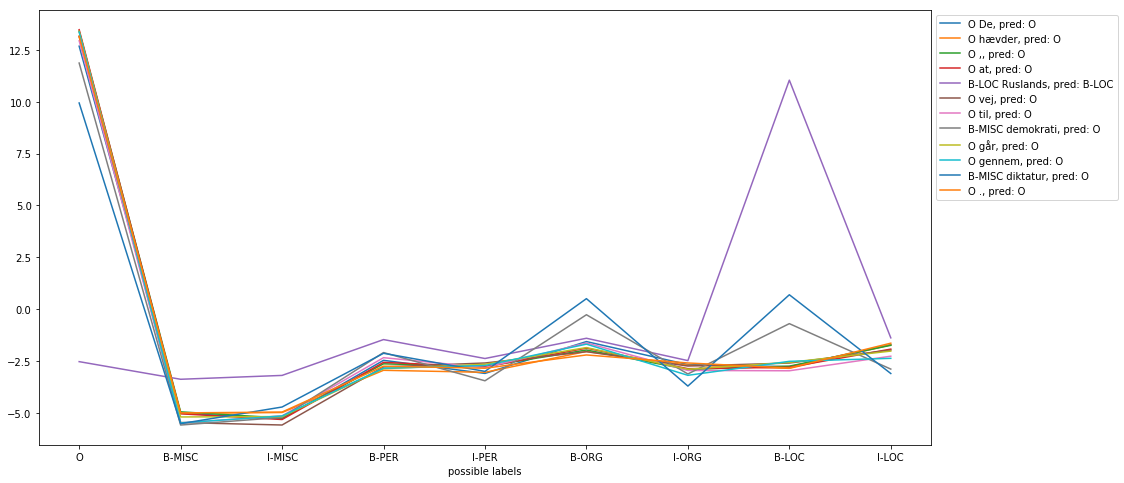

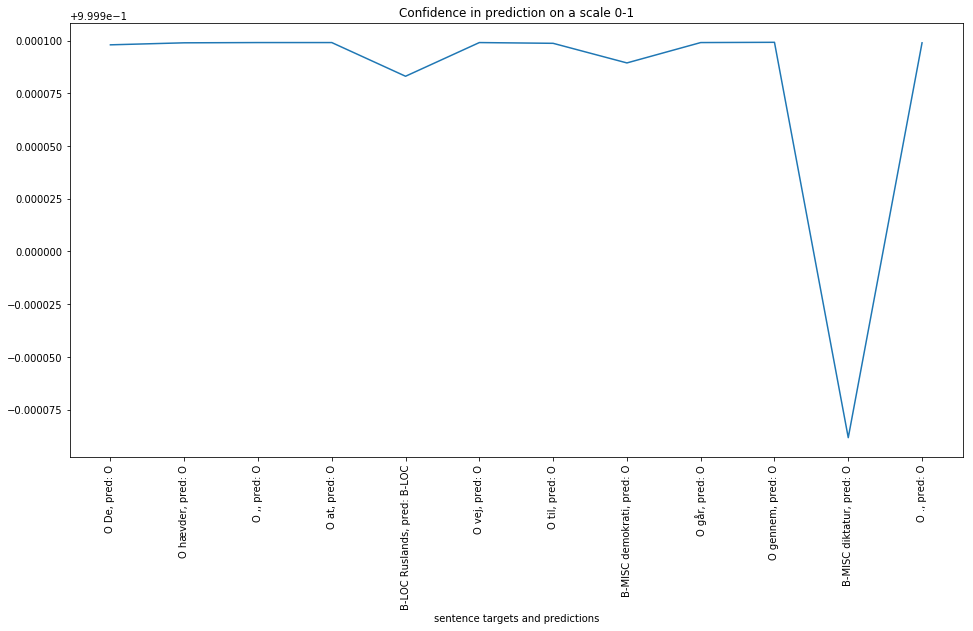

Sentence: ['De', 'hævder', ',', 'at', 'Ruslands', 'vej', 'til', 'demokrati', 'går', 'gennem', 'diktatur', '.']
Targets: ['O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'B-MISC', 'O', 'O', 'B-MISC', 'O']
Predictions: ['O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [645]:
index = 1
# obs: 1, 5, 6, 11, 15, 23, 26, 32, 37, 39, 42, 43, 46, 47, 51, 58, 63, 71, 76, 81, 82, 86, 87, 93, 97, 99

predictions, predictions_probs, outputs = sentence_prediction_analysis(sentences[index], categories[index], True)

## The words that are categorised as MISC

'FDBchefen' is MISC, but 'Statsministeren' is O.

MISC seems random and not very informative and well-defined. Mostly it's adjectives 
saying which country or political party someoneis from.

'tyskerne' is MISC, but 'Brugser' is ORG. Why not PER for 'tyskerne' or MISC for 'Brugser'?

From danlp paper: "This seems to be mainly due to languages, nationalities and adjectives referring, e.g., to nations not being annotated as MISC. Examples are dansk, dansker, europæiske (Danish, Dane, European). In Danish, opposed to in English, such words should not be capitalized and are thus easier to miss by annotators."

In [554]:
for i, sentence in enumerate(categories):
    for j, token in enumerate(sentence):
        if token[2:]=='MISC':
            print(token, sentences[i][j])

B-MISC russiske
B-MISC demokrati
B-MISC diktatur
B-MISC demokratiske
B-MISC demokrati
B-MISC diktatoriske
B-MISC jugoslavisk
B-MISC social-grundtvigianerne
B-MISC indremissionske
B-MISC grundtvigianske-socialdemokratiske
B-MISC danskeres
B-MISC FDBchefen
B-MISC Ikast-Lyngby
B-MISC B-1903-Silkeborg
B-MISC AaB-Vejle
B-MISC FremOB
B-MISC Lyngby-Brøndby
B-MISC Silkeborg-AGF
B-MISC Vejle-Ikast
B-MISC Frem-B
I-MISC 1903
B-MISC AaB-OB
B-MISC DM-guldet
B-MISC Europa
I-MISC Cup
B-MISC Superligaen
B-MISC litauer
B-MISC spanske
B-MISC Sovjet-soldater
B-MISC litauer
B-MISC sovjetiske
B-MISC israelske
B-MISC CNN-journalisterne
B-MISC dansk
B-MISC Brøndby'ere
B-MISC Superliga-finalen
B-MISC Pedal-Ove-sagen
B-MISC The
I-MISC Healer
B-MISC Grammy
B-MISC The
I-MISC Healer
B-MISC 40'erne
B-MISC Dansk
B-MISC danskere
B-MISC Røde-Kro-løjer
B-MISC DANSKE
B-MISC AIDS
B-MISC Hof
B-MISC Tuborg
B-MISC borgerlige
B-MISC socialdemokratiske
B-MISC borgerlige
B-MISC borgerlig
B-MISC Ariostea-mandskabet
B-MISC Orie

## Calibration

In [711]:
bert_preds, _, output_probabilities = get_bert_predictions()
output_probabilities = torch.cat(tuple(output_probabilities), 0)

Percent of probability for O in range 0.01 to 0.99 is 0.339 %.
Percent of probability for B-PER in range 0.01 to 0.99 is 0.239 %.
Percent of probability for I-PER in range 0.01 to 0.99 is 0.02 %.
Percent of probability for B-ORG in range 0.01 to 0.99 is 0.439 %.
Percent of probability for I-ORG in range 0.01 to 0.99 is 0.0798 %.
Percent of probability for B-LOC in range 0.01 to 0.99 is 0.13 %.
Percent of probability for I-LOC in range 0.01 to 0.99 is 0.0299 %.


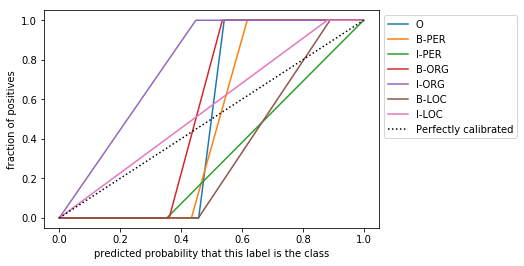

In [778]:
for label_for_calibration in bert.label_list:
    if label_for_calibration[2:]=='MISC':
        continue
    index = bert.label_list.index(label_for_calibration)
    probs = output_probabilities[:,index]
    counter = 0
    for val in probs:
        if val > 0.01 and val < 0.99:
            counter += 1
    print(f'Percent of probability for {label_for_calibration}',
          'in range 0.01 to 0.99 is {:0.3} %.'.format(100*counter/len(probs)))
    true_bin = [int(tok==label_for_calibration) for tok in bert_preds_flattened]
    prob_true, prob_pred = calibration_curve(true_bin, probs, n_bins=10)
    plt.plot(prob_pred, prob_true, label=label_for_calibration)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.ylabel('fraction of positives')
plt.xlabel('predicted probability that this label is the class')
plt.show()

**Explanation of graph above**

0.2 on the x-axis means that the model predicted with a probability of 0.2, that a given class, for instance B-PER, was the correct one. If the model was perfectly calibrated, 20 % of all the B-PER predictions in the same 'bin' as 0.2, would be a correct classification, that is, truely a B-PER word. The y-axis represents this percentage. In the plot above, the value is 0 %, so none of the B-PER words that had a probability of around 0.2 were actually a true choice.

There are very few predictions that have a probability between 1 % and 99 %.